## sigMF STFT on GPU

In [1]:
import os
import itertools
from sklearn.utils import shuffle
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as d
import torch.optim as optim
import torch.nn.functional as F
import torch.nn.modules as mod
import torch.utils.data
import torch.utils.data as data
from torch.nn.utils.rnn import pack_padded_sequence
from torch.nn.utils.rnn import pad_packed_sequence
from torch.autograd import Variable
import numpy as np
import sys
import importlib
import time
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image
import librosa
from scipy import signal
from scipy import stats
from scipy.special import comb
import matplotlib.pyplot as plt
import glob
import json
import pickle
from random import randint, choice
import random
from timeit import default_timer as timer
from torch import istft
# from torchaudio.functional import istft
from sklearn.decomposition import NMF
global GPU, n_fft
GPU = 1
Fs = 1000000
n_fft = 1024
plt.style.use('default')
device = torch.device('cuda:1')
print('Torch version =', torch.__version__, 'CUDA version =', torch.version.cuda)
print('CUDA Device:', device)
print('Is cuda available? =',torch.cuda.is_available())

Torch version = 1.6.0 CUDA version = 10.2
CUDA Device: cuda:1
Is cuda available? = True


In [2]:
# %matplotlib notebook
# %matplotlib inline

#### Machine paths

In [3]:
path_save = "/home/david/sigMF_ML/SVD/UDV_matrix/" # ace
path = "/home/david/sigMF_ML/SVD/" # ACE
print(path)

/home/david/sigMF_ML/SVD/


In [4]:
os.chdir(path)
db = np.fromfile("UHF_lora125_db_snr_hi.sigmf-data", dtype="float32")

In [5]:
def meta_encoder(meta_list, num_classes): 
    a = np.asarray(meta_list, dtype=int)
    return a 

def read_meta(meta_files):
    meta_list = []
    for meta in meta_files:
        all_meta_data = json.load(open(meta))
        meta_list.append(all_meta_data['global']["core:class"])
    meta_list = list(map(int, meta_list))
    return meta_list

def read_num_val(x):
    x = len(meta_list_val)
    return x

#### torch GPU Cuda stft

In [6]:
def gpu(db):
    I = db[0::2]
    Q = db[1::2]
    start = timer()
    w = n_fft
    win = torch.hann_window(w, periodic=True, dtype=None, layout=torch.strided, requires_grad=False).cuda(GPU)
    I_stft = torch.stft(torch.tensor(I).cuda(GPU), n_fft=n_fft, hop_length=n_fft//2, win_length=w, window=win, center=True, normalized=True, onesided=False)
    Q_stft = torch.stft(torch.tensor(Q).cuda(GPU), n_fft=n_fft, hop_length=n_fft//2, win_length=w, window=win, center=True, normalized=True, onesided=False)
    X_stft = I_stft[...,0] + Q_stft[...,0] + I_stft[...,1] + -1*Q_stft[...,1]
    X_stft = torch.cat((X_stft[n_fft//2:],X_stft[:n_fft//2]))
    end = timer()
    print(end - start)
    torch.cuda.empty_cache()
    return X_stft, I_stft, Q_stft

#### scipy CPU stft function

In [7]:
def cpu(db):
    t = len(db)
    db2 = db[0::]
    start = timer()
    db = db.astype(np.float32).view(np.complex64)
    Fs = 1e6
    I_t, I_f, Z = signal.stft(db, fs=Fs, nperseg=n_fft, return_onesided=False)
    Z = np.vstack([Z[n_fft//2:], Z[:n_fft//2]])
    end = timer()
    print(end - start)
    return Z

### GPU Timing

In [8]:
stft_gpu, I_stft, Q_stft = gpu(db)

3.4374439370001255


In [9]:
I_stft.shape, Q_stft.shape, stft_gpu.shape

(torch.Size([1024, 9766, 2]),
 torch.Size([1024, 9766, 2]),
 torch.Size([1024, 9766]))

In [10]:
stft_gpu.shape

torch.Size([1024, 9766])

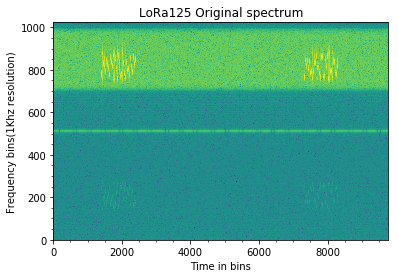

In [11]:
plt.figure(figsize=(9, 6))
fig3 = plt.figure()
plt.imshow(20*np.log10(np.abs(stft_gpu.cpu()+1e-8)), aspect='auto', origin='lower')
title = "LoRa125 Original spectrum"
plt.title(title)
plt.xlabel('Time in bins')
plt.ylabel('Frequency bins(1Khz resolution)')
plt.minorticks_on()
# plt.yticks(np.arange(0,60, 6))
fig3.savefig('lora125_full_spectrum.pdf', format="pdf")
plt.show()

#### GPU SVD

In [12]:
def udv_stft(I_stft,Q_stft):
    start = timer()
    U_I0, D_I0, V_I0 = torch.svd(I_stft[...,0]) 
    U_I1, D_I1, V_I1 = torch.svd(I_stft[...,1]) 
    U_Q0, D_Q0, V_Q0 = torch.svd(Q_stft[...,0]) 
    U_Q1, D_Q1, V_Q1 = torch.svd(Q_stft[...,1]) 
    end = timer()
    print('SVD time: ',end - start)
    return U_I0, D_I0, V_I0, U_I1, D_I1, V_I1, U_Q0, D_Q0, V_Q0, U_Q1, D_Q1, V_Q1

#### Inverse stft 

In [13]:
def ISTFT(db):
    w = n_fft
    win = torch.hann_window(w, periodic=True, dtype=None, layout=torch.strided, requires_grad=False).cuda(GPU)
    start = timer()
    Z = istft(db, n_fft=n_fft, hop_length=n_fft//2, win_length=w, window=win, center=True, normalized=True, onesided=False)
    end = timer()
    print('ISTFT time = ',end - start)
    torch.cuda.empty_cache()
    return Z

#### Re-combine UDV to approximate original signal

In [14]:
def udv(u, d, v, k):
    start = timer()
    UD = torch.mul(u[:, :k], d[:k])
    v = torch.transpose(v,1,0)
    UDV = torch.mm(UD, v[:k, :])
    end = timer()
    print('UDV time: ',end - start)
    return UDV

In [15]:
print(path_save)
os.chdir(path_save)

/home/david/sigMF_ML/SVD/UDV_matrix/


In [16]:
# np.save('I_stft', I_stft.detach().cpu().numpy())
# np.save('Q_stft', Q_stft.detach().cpu().numpy())

### Main function to run all sub function calls

In [17]:
def complete(I_stft,Q_stft, num):
    U_I0, D_I0, V_I0, U_I1, D_I1, V_I1, U_Q0, D_Q0, V_Q0, U_Q1, D_Q1, V_Q1 = udv_stft(I_stft,Q_stft)
    torch.cuda.empty_cache()
    print('UDV I0 shapes = ',U_I0.shape, D_I0.shape, V_I0.shape)
    print('UDV I1 shapes = ',U_I1.shape, D_I1.shape, V_I1.shape)
    print('UDV Q0 shapes = ', U_Q0.shape, D_Q0.shape, V_Q0.shape)
    print('UDV Q1 shapes = ', U_Q1.shape, D_Q1.shape, V_Q1.shape)
    # ------------ I0 ------------------------------------------------------
    np.save('U_I0', U_I0[:, :num].detach().cpu().numpy())
    np.save('D_I0', D_I0[:num].detach().cpu().numpy())
    np.save('V_I0', V_I0[:num, :].detach().cpu().numpy())
    # ------------ I1 ------------------------------------------------------
    np.save('U_I1', U_I1[:, :num].detach().cpu().numpy())
    np.save('D_I1', D_I1[:num].detach().cpu().numpy())
    np.save('V_I1', V_I1[:num, :].detach().cpu().numpy())
    # ------------ Q0 ------------------------------------------------------
    np.save('U_Q0', U_Q0[:, :num].detach().cpu().numpy())
    np.save('D_Q0', D_Q0[:num].detach().cpu().numpy())
    np.save('V_Q0', V_Q0[:num, :].detach().cpu().numpy()) 
    # ------------ Q1 ------------------------------------------------------
    np.save('U_Q1', U_Q1[:, :num].detach().cpu().numpy())
    np.save('D_Q1', D_Q1[:num].detach().cpu().numpy())
    np.save('V_Q1', V_Q1[:num, :].detach().cpu().numpy())    
    # -----------------------------------------------------------------------
    udv_I0 = udv(U_I0, D_I0, V_I0,num)
    udv_I1 = udv(U_I1, D_I1, V_I1,num)
    udv_Q0 = udv(U_Q0, D_Q0, V_Q0,num)
    udv_Q1 = udv(U_Q1, D_Q1, V_Q1,num)
    torch.cuda.empty_cache()
    print('udv I shapes = ',udv_I0.shape,udv_I1.shape)
    print('udv Q shapes = ',udv_Q0.shape,udv_Q1.shape)
    # -------------stack and transpose----------------------------------------
    UDV_I = torch.stack([udv_I0,udv_I1])
    UDV_I = torch.transpose(UDV_I,2,0)
    UDV_I = torch.transpose(UDV_I,1,0)
    UDV_Q = torch.stack([udv_Q0,udv_Q1])
    UDV_Q = torch.transpose(UDV_Q,2,0)
    UDV_Q = torch.transpose(UDV_Q,1,0)
    torch.cuda.empty_cache()
    #--------------------------------------------------------------------------
    I = ISTFT(UDV_I)
    Q = ISTFT(UDV_Q)
    torch.cuda.empty_cache()
    I = I.detach().cpu().numpy()
    Q = Q.detach().cpu().numpy()
    end = len(I)*2
    IQ_SVD = np.zeros(len(I)*2)
    IQ_SVD[0:end:2] = I
    IQ_SVD[1:end:2] = Q 
    IQ_SVD = IQ_SVD.astype(np.float32).view(np.complex64)
    return IQ_SVD

In [18]:
torch.cuda.empty_cache()

### Perform SVD on IQ stft data

In [19]:
num = 28 # number to reconstruct SVD matrix from
IQ_SVD = complete(I_stft,Q_stft, num)

SVD time:  2.530435230999956
UDV I0 shapes =  torch.Size([1024, 1024]) torch.Size([1024]) torch.Size([9766, 1024])
UDV I1 shapes =  torch.Size([1024, 1024]) torch.Size([1024]) torch.Size([9766, 1024])
UDV Q0 shapes =  torch.Size([1024, 1024]) torch.Size([1024]) torch.Size([9766, 1024])
UDV Q1 shapes =  torch.Size([1024, 1024]) torch.Size([1024]) torch.Size([9766, 1024])
UDV time:  0.06358970300016153
UDV time:  0.0009965259998807596
UDV time:  0.0007733690001714422
UDV time:  0.0007128309998734039
udv I shapes =  torch.Size([1024, 9766]) torch.Size([1024, 9766])
udv Q shapes =  torch.Size([1024, 9766]) torch.Size([1024, 9766])
ISTFT time =  0.00878841099984129
ISTFT time =  0.00768049900011647


### Write reconstructed IQ file to file

In [22]:
from array import array
IQ_file = open("lora125_28", 'wb')
IQ_SVD.tofile(IQ_file)
IQ_file.close()

In [23]:
def compression(m,n,num):
    k = num
    comp = m*n/(m*k+n*k+k)
    return comp

In [26]:
num = 28
m = 1024
n = 10000
lora_comp = compression(m,n,num)

In [27]:
lora_comp

33.17136378360868

In [28]:
lora_comp = 40*1e6/225600

In [29]:
lora_comp

177.3049645390071